In [ ]:
import tensorflow as tf

# Kiểm tra xem GPU có khả dụng không
gpu_available = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_available))

if gpu_available:
    print("GPU is available.")
    # In thông tin chi tiết về GPU (nếu có)
    for gpu in gpu_available:
        print("Name:", gpu.name, "Type:", gpu.device_type)
else:
    print("GPU is NOT available.")

Num GPUs Available:  1
GPU is available.
Name: /physical_device:GPU:0 Type: GPU


In [ ]:
# Tạo thư mục chứa dữ liệu đã tiền xử lý
import os
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

source_path = r"/content/drive/MyDrive/dataset_3_balanced"



In [ ]:
!ls /content/drive/MyDrive/dataset_3_balanced

test  train  validation


In [ ]:
!pwd

/content


In [ ]:
# Tạo các bộ tải dữ liệu để dùng trong huấn luyện
def create_dataset_generators(data_dir, batch_size=32):
    # Tăng cường nhẹ cho tập train khi huấn luyện (có thể bỏ nếu đã làm augmentation ở trên)
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Chuẩn hóa pixel về [0, 1]
        # Thêm augmentation nhẹ khi huấn luyện (tùy chọn)
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Chỉ rescale cho validation và test
    valid_test_datagen = ImageDataGenerator(rescale=1./255)

    # Tạo generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = valid_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'validation'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator


In [ ]:
balanced_dir = "/content/drive/MyDrive/dataset_3_balanced"
target_size = (224, 224)

In [ ]:
# Tạo generators từ dữ liệu đã cân bằng
train_gen, val_gen, test_gen = create_dataset_generators(balanced_dir, batch_size=32)


Found 2266 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


Transfer với mobilenetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Tạo mô hình từ đầu
def create_custom_model(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Hoặc sử dụng transfer learning
def create_transfer_model(base_model='mobilenetv2', input_shape=(224, 224, 3), num_classes=4):
    if base_model == 'mobilenetv2':
        base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model == 'resnet50':
        base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model == 'efficientnet':
        base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model")

    # Đóng băng các lớp của mô hình cơ sở
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Chọn loại mô hình muốn xây dựng
# model = create_custom_model()  # Mô hình từ đầu
model = create_transfer_model('mobilenetv2')  # Transfer learning với MobileNetV2

# Biên dịch mô hình
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Thiết lập callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# Huấn luyện mô hình
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

# Đánh giá mô hình trên tập test
test_results = model.evaluate(test_gen)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6251 - loss: 0.9801 

71/71 ━━━━━━━━━━━━━━━━━━━━ 994s 14s/step - accuracy: 0.6267 - loss: 0.9761 - val_accuracy: 0.8088 - val_loss: 0.4915 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8276 - loss: 0.4358

71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 509ms/step - accuracy: 0.8277 - loss: 0.4355 - val_accuracy: 0.8127 - val_loss: 0.5377 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8725 - loss: 0.3478

71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 494ms/step - accuracy: 0.8725 - loss: 0.3475 - val_accuracy: 0.8625 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8796 - loss: 0.3140

71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.8796 - loss: 0.3139 - val_accuracy: 0.8665 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8990 - loss: 0.2962

71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - accuracy: 0.8990 - loss: 0.2960 - val_accuracy: 0.8845 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 496ms/step - accuracy: 0.9009 - loss: 0.2492 - val_accuracy: 0.8486 - val_loss: 0.4205 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 499ms/step - accuracy: 0.9147 - loss: 0.2349 - val_accuracy: 0.8725 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9248 - loss: 0.2152

71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 499ms/step - accuracy: 0.9247 - loss: 0.2154 - val_accuracy: 0.8865 - val_loss: 0.3199 - learning_rate: 0.0010
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 488ms/step - accuracy: 0.9262 - loss: 0.2197 - val_accuracy: 0.8765 - val_loss: 0.3706 - learning_rate: 0.0010
Epoch 10/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9330 - loss: 0.1836

71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 485ms/step - accuracy: 0.9330 - loss: 0.1838 - val_accuracy: 0.8944 - val_loss: 0.3402 - learning_rate: 0.0010
Epoch 11/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 490ms/step - accuracy: 0.9392 - loss: 0.1568 - val_accuracy: 0.8745 - val_loss: 0.3730 - learning_rate: 1.0000e-04
Epoch 12/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 500ms/step - accuracy: 0.9478 - loss: 0.1597 - val_accuracy: 0.8685 - val_loss: 0.3666 - learning_rate: 1.0000e-04
Epoch 13/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 492ms/step - accuracy: 0.9563 - loss: 0.1331 - val_accuracy: 0.8725 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 14/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 481ms/step - accuracy: 0.9566 - loss: 0.1345 - val_accuracy: 0.8645 - val_loss: 0.3841 - learning_rate: 1.0000e-04
Epoch 15/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.9590 - loss: 0.1204 - val_accuracy: 0.8725 - val_loss: 0.3736 - learning_rate: 1.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.8719 - loss: 0.3

Transfer Learning: Tái sử dụng mô hình đã được huấn luyện trên tập ImageNet (hàng triệu ảnh)
MobileNetV2: Mô hình nhẹ, hiệu quả, tốc độ cao, thích hợp cho nhiều thiết bị
include_top=False: Loại bỏ các lớp fully-connected ở cuối mô hình gốc
weights='imagenet': Sử dụng trọng số đã huấn luyện trên ImageNet


Phân Tích Quy Trình:
Tại sao dùng Transfer Learning?

Tận dụng được kiến thức từ mô hình đã huấn luyện trên dữ liệu lớn
Giảm thời gian huấn luyện và yêu cầu dữ liệu
Hiệu quả cao hơn khi huấn luyện từ đầu, đặc biệt với dữ liệu y tế có kích thước hạn chế
Tại sao chọn MobileNetV2?

Nhẹ và nhanh (thích hợp với phần cứng hạn chế)
Hiệu quả cao trong nhiều bài toán phân loại ảnh
Cân bằng giữa hiệu suất và kích thước mô hình
Tiêu chí đánh giá:

Accuracy: % mẫu được phân loại đúng
Loss: Mức độ sai lệch giữa dự đoán và nhãn thật
Qua quá trình này, mô hình sẽ học cách phân loại 4 loại ảnh MRI não thành các nhóm: Glioma, Meningioma, No Tumor và Pituitary, dựa trên các đặc trưng ảnh đã được học từ ImageNet và tinh chỉnh cho dữ liệu MRI cụ thể.

test

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.8702 - loss: 0.3634
Độ chính xác trên tập test: 0.8740
Loss trên tập test: 0.3758
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 514ms/step

Báo cáo phân loại chi tiết:
              precision    recall  f1-score   support

      Glioma       0.94      0.94      0.94        80
  Meningioma       0.85      0.73      0.79        63
    No_Tumor       0.93      0.82      0.87        49
   Pituitary       0.78      1.00      0.88        54

    accuracy                           0.87       246
   macro avg       0.88      0.87      0.87       246
weighted avg       0.88      0.87      0.87       246

Ma trận nhầm lẫn không chuẩn hóa


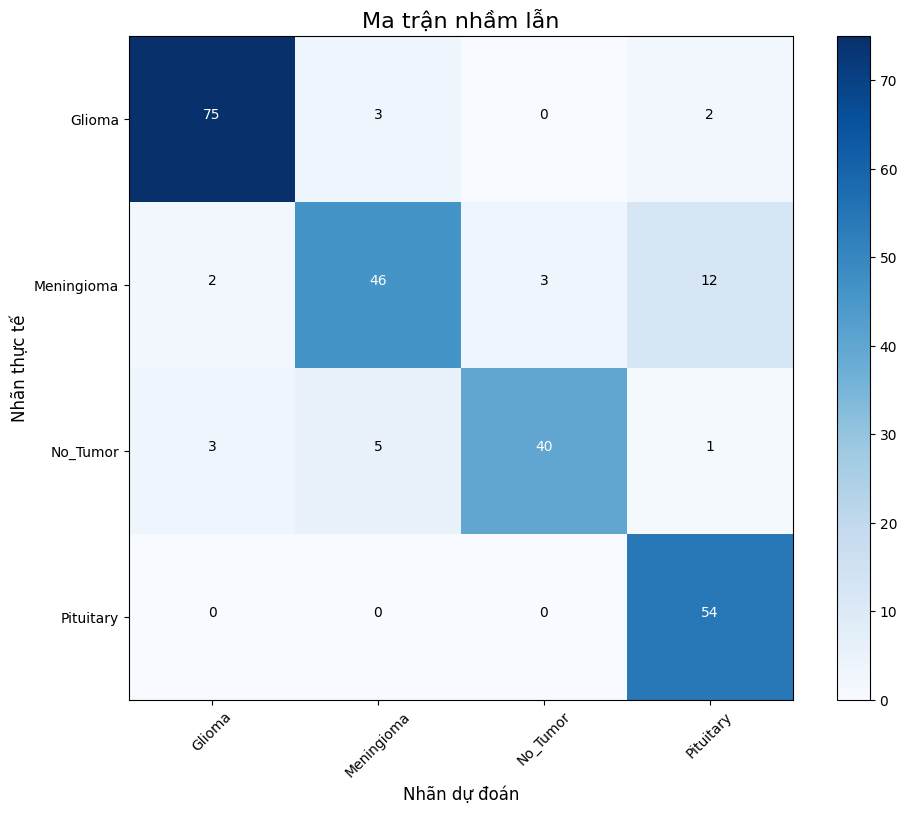

Ma trận nhầm lẫn được chuẩn hóa


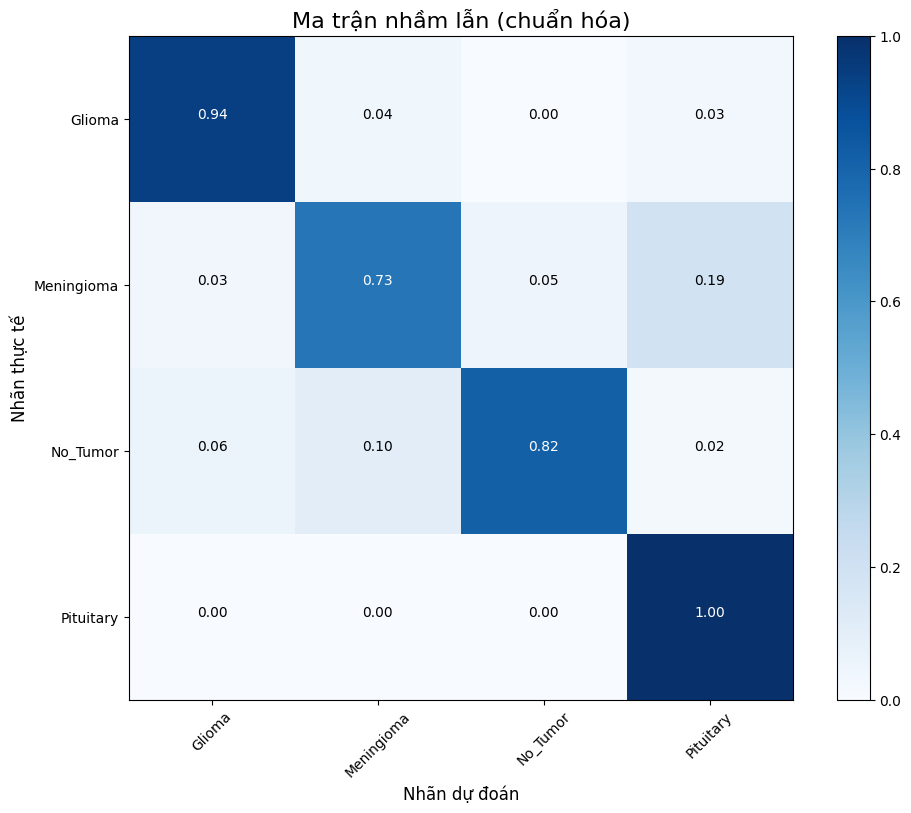

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


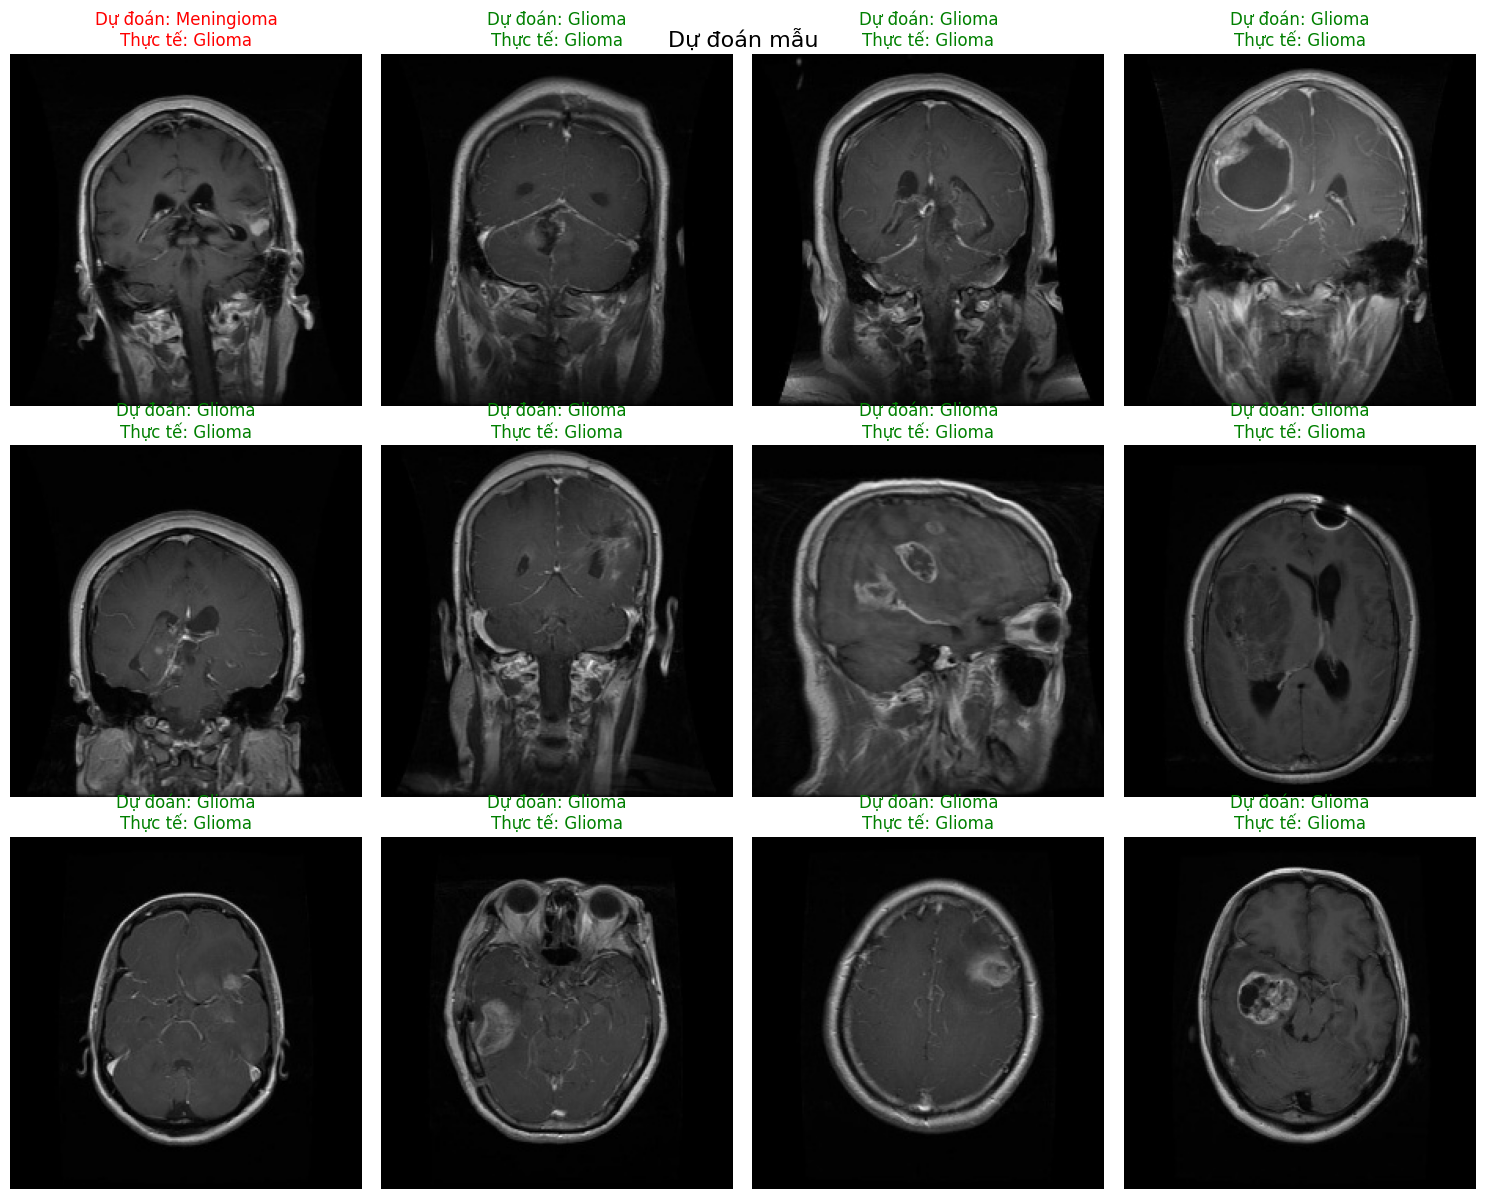

Độ chính xác lớp Glioma: 0.9375
Độ chính xác lớp Meningioma: 0.7302
Độ chính xác lớp No_Tumor: 0.8163
Độ chính xác lớp Pituitary: 1.0000


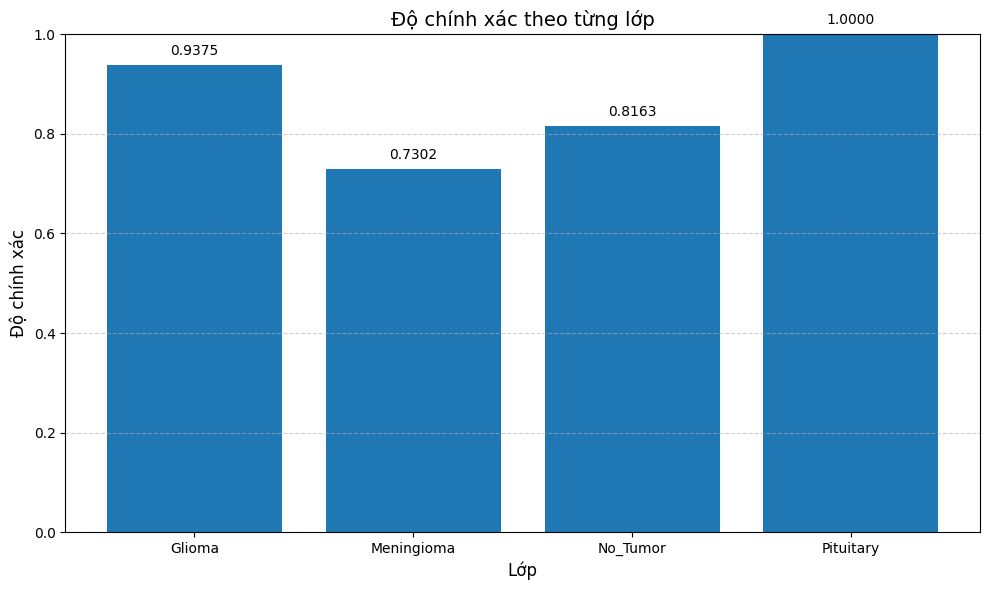

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import itertools

# 1. Tải mô hình đã huấn luyện (nếu đã lưu)
# Nếu bạn đã sử dụng ModelCheckpoint để lưu mô hình
model = load_model('best_model.h5')
# Hoặc sử dụng model đã huấn luyện nếu đang trong cùng session

# 2. Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_gen)
print(f"Độ chính xác trên tập test: {test_acc:.4f}")
print(f"Loss trên tập test: {test_loss:.4f}")

# 3. Dự đoán trên tập test
# Đặt lại generator để đảm bảo dự đoán đúng thứ tự
test_gen.reset()

# Dự đoán
y_pred = model.predict(test_gen, steps=len(test_gen))
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
# Lưu ý: vì generator có thể padding batch cuối cùng, nên chỉ lấy đúng số mẫu test
true_classes = test_gen.classes[:len(y_pred_classes)]

# Lấy tên các lớp
class_labels = list(test_gen.class_indices.keys())

# 4. Báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết:")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

# 5. Vẽ ma trận nhầm lẫn
def plot_confusion_matrix(cm, classes, normalize=False, title='Ma trận nhầm lẫn', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Ma trận nhầm lẫn được chuẩn hóa")
    else:
        print("Ma trận nhầm lẫn không chuẩn hóa")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Nhãn thực tế', fontsize=12)
    plt.xlabel('Nhãn dự đoán', fontsize=12)
    plt.show()

# Tính ma trận nhầm lẫn
cnf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn không chuẩn hóa
plot_confusion_matrix(cnf_matrix, classes=class_labels, title='Ma trận nhầm lẫn')

# Vẽ ma trận nhầm lẫn chuẩn hóa
plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True, title='Ma trận nhầm lẫn (chuẩn hóa)')

# 6. Vẽ đường cong học tập (nếu bạn có history từ quá trình huấn luyện)
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Vẽ đường cong accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Vẽ đường cong loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Nếu bạn có history, hãy vẽ các đường cong học tập
# Bỏ comment dòng dưới nếu bạn có history
# plot_learning_curves(history)

# 7. Hiển thị một số ảnh và dự đoán
def display_predictions(generator, model, num_samples=12):
    plt.figure(figsize=(15, 12))

    # Lấy batch đầu tiên để hiển thị
    generator.reset()
    batch_x, batch_y = next(generator)

    # Dự đoán
    predictions = model.predict(batch_x)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_y, axis=1)

    # Lấy tên lớp
    classes = list(generator.class_indices.keys())

    # Hiển thị ảnh cùng với dự đoán
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(3, 4, i+1)
        plt.imshow(batch_x[i])

        # Xác định màu cho tiêu đề (xanh nếu đúng, đỏ nếu sai)
        if pred_classes[i] == true_classes[i]:
            color = 'green'
        else:
            color = 'red'

        # Hiển thị tiêu đề
        title = f"Dự đoán: {classes[pred_classes[i]]}\nThực tế: {classes[true_classes[i]]}"
        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Dự đoán mẫu', fontsize=16, y=0.98)
    plt.show()

# Hiển thị một số dự đoán
display_predictions(test_gen, model)

# 8. Đánh giá tỉ lệ đúng của từng lớp
class_acc = {}
for i, class_name in enumerate(class_labels):
    # Lấy chỉ số của các mẫu thuộc lớp i
    class_indices = np.where(true_classes == i)[0]
    # Tính accuracy cho lớp này
    class_acc[class_name] = accuracy_score(
        true_classes[class_indices],
        y_pred_classes[class_indices]
    )
    print(f"Độ chính xác lớp {class_name}: {class_acc[class_name]:.4f}")

# Vẽ biểu đồ độ chính xác theo lớp
plt.figure(figsize=(10, 6))
plt.bar(class_acc.keys(), class_acc.values())
plt.title('Độ chính xác theo từng lớp', fontsize=14)
plt.xlabel('Lớp', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(class_acc.values()):
    plt.text(i, v+0.02, f"{v:.4f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

**EfficientNetB3 - Mô Hình Cân Bằng Hiệu Suất và Hiệu Quả**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Tạo model EfficientNetB3 với fine-tuning
def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=4):
    # Load mô hình EfficientNetB3 đã huấn luyện trên ImageNet
    base_model = applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Đóng băng các lớp đầu (70%)
    for layer in base_model.layers[:int(len(base_model.layers)*0.7)]:
        layer.trainable = False

    # Xây dựng mô hình với các lớp bổ sung
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Thêm regularization để giảm overfitting
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

# Tạo mô hình
model = create_efficientnet_model()
model.summary()

# Biên dịch mô hình với optimizer tùy chỉnh
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        'best_efficientnet_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_accuracy',
        verbose=1
    ),
    ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        monitor='val_loss',
        verbose=1
    ),
    # Thêm TensorBoard để theo dõi quá trình huấn luyện (tùy chọn)
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

# Huấn luyện - đã loại bỏ workers và use_multiprocessing
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

# Đánh giá mô hình trên tập test
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,712,051 (44.68 MB)

 Trainable params: 9,317,378 (35.54 MB)

 Non-trainable params: 2,394,673 (9.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.3383 - loss: 1.5630 - precision: 0.3733 - recall: 0.2158 
Epoch 1: val_accuracy improved from -inf to 0.32869, saving model to best_efficientnet_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 1957s 27s/step - accuracy: 0.3391 - loss: 1.5616 - precision: 0.3743 - recall: 0.2165 - val_accuracy: 0.3287 - val_loss: 1.3676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4159 - loss: 1.3779 - precision: 0.4717 - recall: 0.2880
Epoch 2: val_accuracy improved from 0.32869 to 0.60159, saving model to best_efficientnet_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 542ms/step - accuracy: 0.4162 - loss: 1.3771 - precision: 0.4721 - recall: 0.2884 - val_accuracy: 0.6016 - val_loss: 1.3401 - val_precision: 0.5000 - val_recall: 0.0020 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4761 - loss: 1.2627 - precision: 0.5477 - recall: 0.3486
Epoch 3: val_accuracy did not improve from 0.60159
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 520ms/step - accuracy: 0.4761 - loss: 1.2625 - precision: 0.5476 - recall: 0.3487 - val_accuracy: 0.5498 - val_loss: 1.2672 - val_precision: 0.6800 - val_recall: 0.0677 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4616 - loss: 1.2527 - precision: 0.5300 - recall: 0.3444
Epoch 4: val_accuracy did not improve from 0.60159
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 523ms/step - accuracy: 0.4619 - loss: 1.2522 - precision: 0.5304 - recall: 0.3446 - val_accuracy: 0.5857 - val_loss: 1.1903 - val_precision: 0.6037 - val_recall: 0.1

71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 535ms/step - accuracy: 0.4760 - loss: 1.2152 - precision: 0.5560 - recall: 0.3490 - val_accuracy: 0.6155 - val_loss: 1.1087 - val_precision: 0.6631 - val_recall: 0.4940 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5213 - loss: 1.1464 - precision: 0.6077 - recall: 0.3957
Epoch 6: val_accuracy improved from 0.61554 to 0.62749, saving model to best_efficientnet_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 542ms/step - accuracy: 0.5213 - loss: 1.1465 - precision: 0.6076 - recall: 0.3955 - val_accuracy: 0.6275 - val_loss: 1.0109 - val_precision: 0.6675 - val_recall: 0.5398 - learning_rate: 1.0000e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5184 - loss: 1.1366 - precision: 0.5895 - recall: 0.3916
Epoch 7: val_accuracy improved from 0.62749 to 0.65936, saving model to best_efficientnet_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 529ms/step - accuracy: 0.5185 - loss: 1.1365 - precision: 0.5896 - recall: 0.3917 - val_accuracy: 0.6594 - val_loss: 0.8984 - val_precision: 0.6912 - val_recall: 0.5797 - learning_rate: 1.0000e-04
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5054 - loss: 1.1299 - precision: 0.5903 - recall: 0.3820
Epoch 8: val_accuracy did not improve from 0.65936
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - accuracy: 0.5055 - loss: 1.1299 - precision: 0.5904 - recall: 0.3820 - val_accuracy: 0.6554 - val_loss: 0.8726 - val_precision: 0.6853 - val_recall: 0.6335 - learning_rate: 1.0000e-04
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5229 - loss: 1.1172 - precision: 0.6129 - recall: 0.4016
Epoch 9: val_accuracy did not improve from 0.65936
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 505ms/step - accuracy: 0.5230 - loss: 1.1172 - precision: 0.6128 - recall: 0.4016 - val_accuracy: 0.6155 - val_loss: 0.9157 - val_precision: 0.6357 - val_recall: 0.5

71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 531ms/step - accuracy: 0.5337 - loss: 1.1068 - precision: 0.6306 - recall: 0.4139 - val_accuracy: 0.7191 - val_loss: 0.7598 - val_precision: 0.7545 - val_recall: 0.6733 - learning_rate: 1.0000e-04
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.5267 - loss: 1.1197 - precision: 0.6116 - recall: 0.4193
Epoch 11: val_accuracy improved from 0.71912 to 0.72311, saving model to best_efficientnet_model.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.5269 - loss: 1.1192 - precision: 0.6119 - recall: 0.4194 - val_accuracy: 0.7231 - val_loss: 0.7470 - val_precision: 0.7441 - val_recall: 0.6892 - learning_rate: 1.0000e-04
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.5556 - loss: 1.0449 - precision: 0.6352 - recall: 0.4305
Epoch 12: val_accuracy did not improve from 0.72311
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 512ms/step - accuracy: 0.5556 - loss: 1.0447 - precision: 0.6354 - recall: 0.4306 - val_accuracy: 0.7171 - val_loss: 0.7291 - val_precision: 0.7436 - val_recall: 0.6932 - learning_rate: 1.0000e-04
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.5722 - loss: 1.0100 - precision: 0.6615 - recall: 0.4448
Epoch 13: val_accuracy did not improve from 0.72311
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.5722 - loss: 1.0101 - precision: 0.6615 - recall: 0.4448 - val_accuracy: 0.6992 - val_loss: 0.7439 - val_precision: 0.7373 - val_recall:

71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 517ms/step - accuracy: 0.5759 - loss: 1.0326 - precision: 0.6654 - recall: 0.4515 - val_accuracy: 0.7371 - val_loss: 0.6327 - val_precision: 0.7746 - val_recall: 0.7052 - learning_rate: 1.0000e-04
Epoch 19/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6011 - loss: 0.9604 - precision: 0.6970 - recall: 0.5072
Epoch 19: val_accuracy did not improve from 0.73705
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 518ms/step - accuracy: 0.6009 - loss: 0.9605 - precision: 0.6969 - recall: 0.5071 - val_accuracy: 0.6474 - val_loss: 0.9158 - val_precision: 0.6596 - val_recall: 0.6175 - learning_rate: 1.0000e-04
Epoch 20/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6054 - loss: 0.9741 - precision: 0.6908 - recall: 0.4788
Epoch 20: val_accuracy did not improve from 0.73705
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 528ms/step - accuracy: 0.6053 - loss: 0.9742 - precision: 0.6908 - recall: 0.4788 - val_accuracy: 0.7191 - val_loss: 0.6609 - val_precision: 0.7694 - val_recall:

##  ResNet50V2 với Attention

In [ ]:
from tensorflow.keras import layers, models, applications
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Tạo Attention Layer
def attention_block(inputs, filters):
    x = layers.Conv2D(filters, kernel_size=1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    attention = layers.Conv2D(1, kernel_size=1)(x)
    attention = layers.BatchNormalization()(attention)
    attention = layers.Activation('sigmoid')(attention)

    return layers.Multiply()([inputs, attention])

# Tạo mô hình ResNet50V2 với Attention
def create_resnet_attention_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Đóng băng các lớp ban đầu
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Lấy đầu ra của base model
    x = base_model.output

    # Thêm Attention Block
    x = attention_block(x, 2048)

    # Thêm các lớp phân loại
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Tạo mô hình
model = create_resnet_attention_model()
model.summary()

# Biên dịch
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint('best_resnet_attention_model.h5', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=7, min_lr=1e-6)
]

# Huấn luyện
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 30,396,425 (115.95 MB)

 Trainable params: 27,387,399 (104.47 MB)

 Non-trainable params: 3,009,026 (11.48 MB)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.5961 - loss: 1.0026

71/71 ━━━━━━━━━━━━━━━━━━━━ 107s 948ms/step - accuracy: 0.5982 - loss: 0.9977 - val_accuracy: 0.7311 - val_loss: 1.3330 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9244 - loss: 0.2069

71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 604ms/step - accuracy: 0.9246 - loss: 0.2064 - val_accuracy: 0.9462 - val_loss: 0.2182 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9628 - loss: 0.1117

71/71 ━━━━━━━━━━━━━━━━━━━━ 78s 552ms/step - accuracy: 0.9627 - loss: 0.1120 - val_accuracy: 0.9482 - val_loss: 0.2293 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.9765 - loss: 0.0851

71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.9765 - loss: 0.0850 - val_accuracy: 0.9522 - val_loss: 0.2312 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9788 - loss: 0.0673

71/71 ━━━━━━━━━━━━━━━━━━━━ 43s 609ms/step - accuracy: 0.9788 - loss: 0.0673 - val_accuracy: 0.9602 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 541ms/step - accuracy: 0.9844 - loss: 0.0395 - val_accuracy: 0.9542 - val_loss: 0.2203 - learning_rate: 1.0000e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9804 - loss: 0.0563

71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 581ms/step - accuracy: 0.9804 - loss: 0.0564 - val_accuracy: 0.9641 - val_loss: 0.1926 - learning_rate: 1.0000e-04
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9931 - loss: 0.0273

71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 634ms/step - accuracy: 0.9931 - loss: 0.0273 - val_accuracy: 0.9661 - val_loss: 0.2212 - learning_rate: 1.0000e-04
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.9952 - loss: 0.0273 - val_accuracy: 0.9482 - val_loss: 0.2444 - learning_rate: 1.0000e-04
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 537ms/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.9661 - val_loss: 0.1855 - learning_rate: 1.0000e-04
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9934 - loss: 0.0169

71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 590ms/step - accuracy: 0.9934 - loss: 0.0169 - val_accuracy: 0.9721 - val_loss: 0.1518 - learning_rate: 1.0000e-04
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 541ms/step - accuracy: 0.9932 - loss: 0.0259 - val_accuracy: 0.9622 - val_loss: 0.1637 - learning_rate: 1.0000e-04
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 535ms/step - accuracy: 0.9888 - loss: 0.0217 - val_accuracy: 0.9681 - val_loss: 0.1669 - learning_rate: 1.0000e-04
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 530ms/step - accuracy: 0.9932 - loss: 0.0278 - val_accuracy: 0.9482 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Epoch 15/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 536ms/step - accuracy: 0.9902 - loss: 0.0286 - val_accuracy: 0.9701 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 16/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9661 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 17/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 548ms/step - accuracy

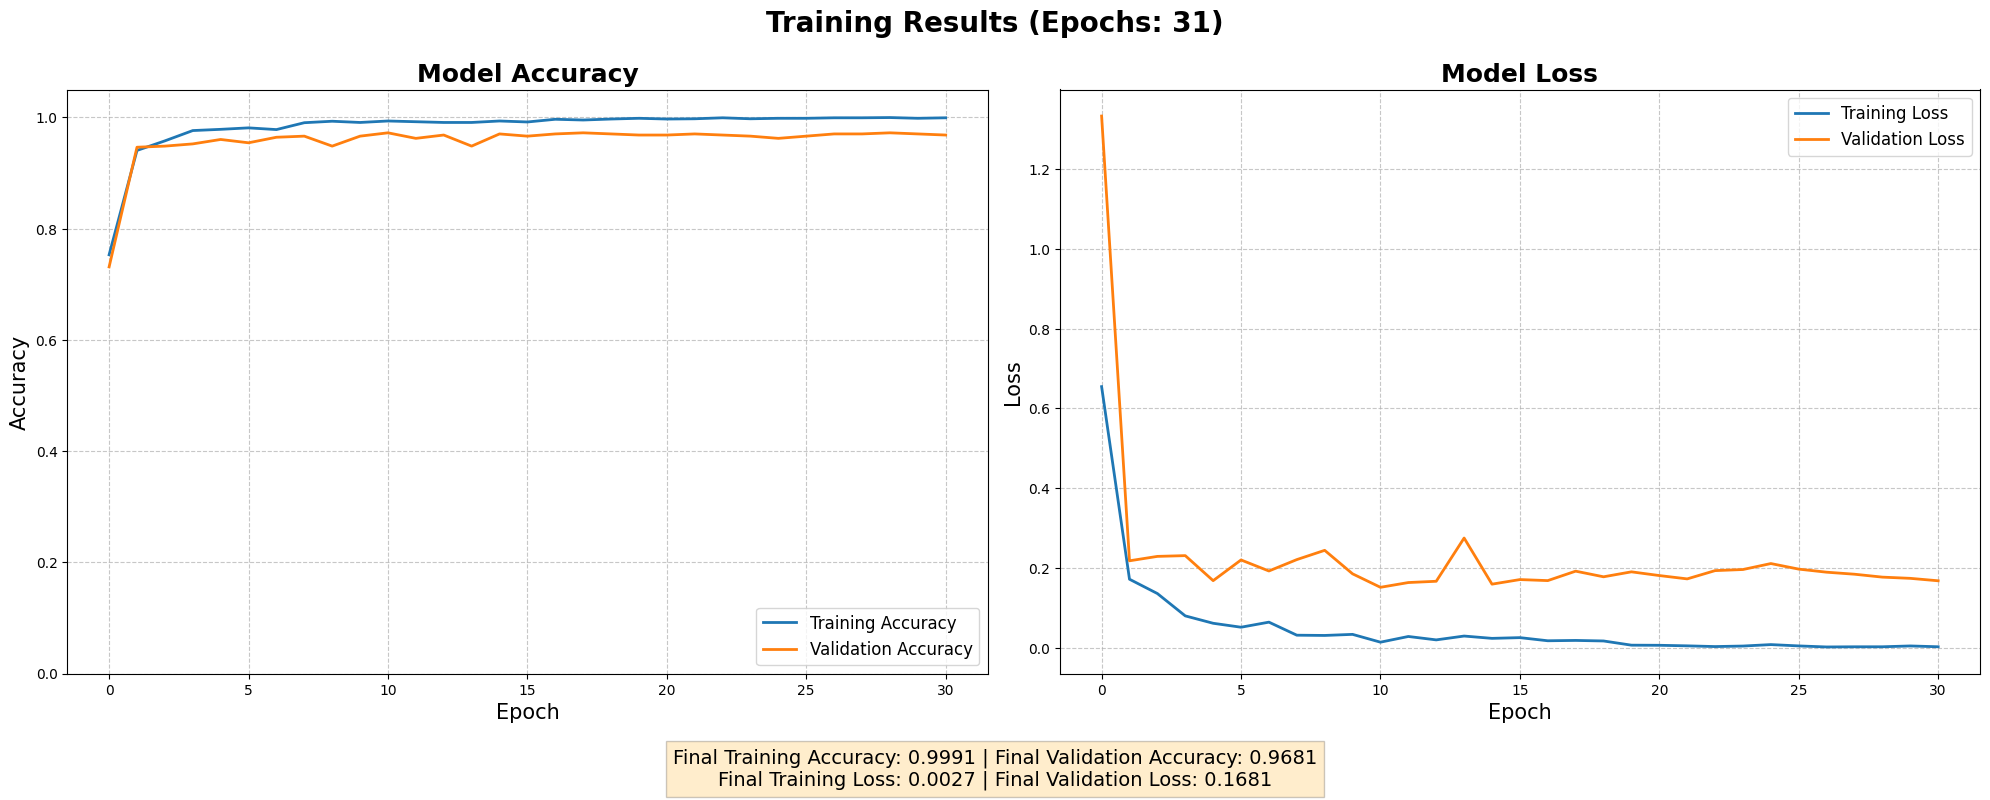

✅ Model seems to be generalizing well (gap: 0.031)
Evaluating on validation set...
Validation Loss: 0.1518, Validation Accuracy: 0.9721

Evaluating on test set...
Test Loss: 0.2382, Test Accuracy: 0.9634
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 575ms/step


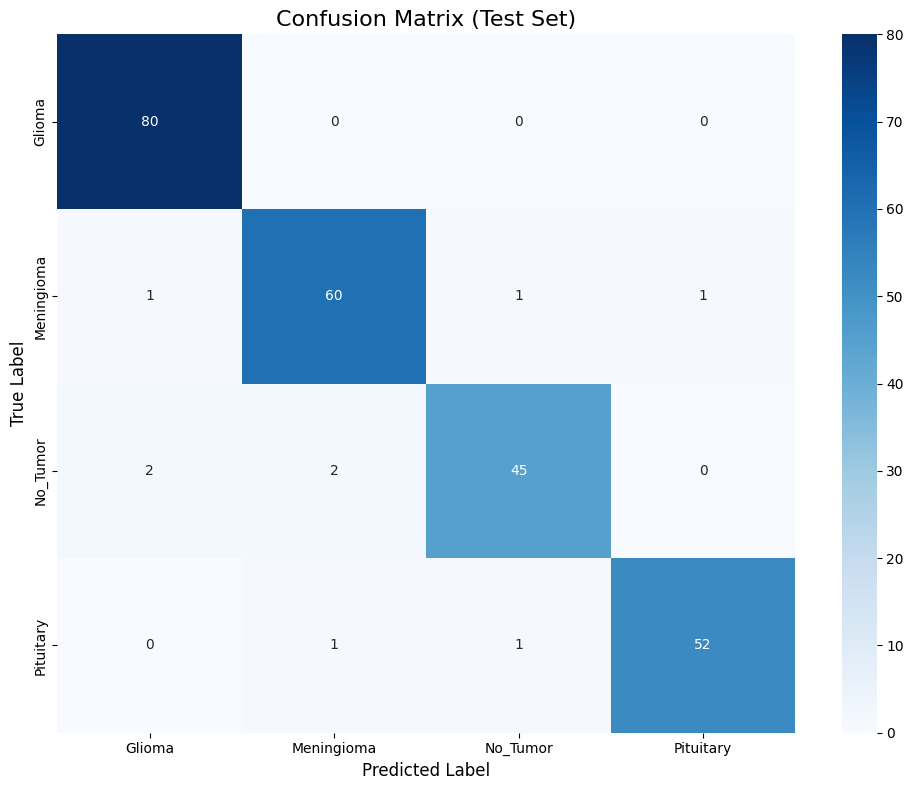


Classification Report (Test Set):
              precision    recall  f1-score   support

      Glioma       0.96      1.00      0.98        80
  Meningioma       0.95      0.95      0.95        63
    No_Tumor       0.96      0.92      0.94        49
   Pituitary       0.98      0.96      0.97        54

    accuracy                           0.96       246
   macro avg       0.96      0.96      0.96       246
weighted avg       0.96      0.96      0.96       246


Potential issues to investigate:
- Unusually high accuracy may indicate data leakage
- Check for duplicates between train/val/test sets
- Verify preprocessing steps are separate for each set
- Consider more challenging validation methods (e.g., k-fold)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Visualize the training history of the model including accuracy and loss
    metrics for both training and validation sets.

    Args:
        history: History object returned by model.fit()
    """
    # Create a figure with 2 subplots in one row
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.set_xlabel('Epoch', fontsize=15)
    ax1.set_ylim([0, 1.05])
    ax1.legend(loc='lower right', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Highlight potential overfitting
    if len(history.history['accuracy']) > 5:
        train_final = np.mean(history.history['accuracy'][-5:])
        val_final = np.mean(history.history['val_accuracy'][-5:])
        if train_final - val_final > 0.05:
            ax1.annotate(f'Potential Overfitting\nGap: {train_final-val_final:.3f}',
                        xy=(len(history.history['accuracy'])-3, (train_final+val_final)/2),
                        xytext=(len(history.history['accuracy'])-10, 0.6),
                        arrowprops=dict(facecolor='red', shrink=0.05),
                        bbox=dict(boxstyle="round,pad=0.5", fc="pink", alpha=0.8),
                        fontsize=12)

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=18, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.set_xlabel('Epoch', fontsize=15)
    ax2.legend(loc='upper right', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Show final values
    epochs = len(history.history['accuracy'])
    train_acc_final = history.history['accuracy'][-1]
    val_acc_final = history.history['val_accuracy'][-1]
    train_loss_final = history.history['loss'][-1]
    val_loss_final = history.history['val_loss'][-1]

    fig.suptitle(f'Training Results (Epochs: {epochs})', fontsize=20, fontweight='bold', y=0.98)

    # Add text summary at the bottom
    plt.figtext(0.5, 0.01,
                f'Final Training Accuracy: {train_acc_final:.4f} | Final Validation Accuracy: {val_acc_final:.4f}\n'
                f'Final Training Loss: {train_loss_final:.4f} | Final Validation Loss: {val_loss_final:.4f}',
                ha="center", fontsize=14, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.15)
    plt.show()

    # Return a simple analysis of whether overfitting might be happening
    if epochs > 5:
        gap = train_acc_final - val_acc_final
        if gap > 0.1:
            print(f"⚠️ WARNING: Potential significant overfitting detected (gap: {gap:.3f})")
        elif gap > 0.05:
            print(f"⚠️ WARNING: Some overfitting may be occurring (gap: {gap:.3f})")
        else:
            print(f"✅ Model seems to be generalizing well (gap: {gap:.3f})")

        # Check for unusually high accuracy
        if val_acc_final > 0.98:
            print(f"⚠️ WARNING: Unusually high validation accuracy ({val_acc_final:.3f}). Verify there's no data leakage.")

# Example usage:
# plot_training_history(history)
def analyze_high_accuracy_model(model, val_gen, test_gen):
    """
    Performs in-depth analysis for models with suspiciously high accuracy
    """
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    # 1. Evaluate on validation set
    print("Evaluating on validation set...")
    val_results = model.evaluate(val_gen, verbose=0)
    print(f"Validation Loss: {val_results[0]:.4f}, Validation Accuracy: {val_results[1]:.4f}")

    # 2. Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = model.evaluate(test_gen, verbose=0)
    print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

    # 3. Generate predictions and confusion matrix for test set
    y_true = test_gen.classes
    class_names = list(test_gen.class_indices.keys())

    # Get predictions
    test_gen.reset()
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Check for potential issues
    print("\nPotential issues to investigate:")
    if np.sum(np.diag(cm)) / np.sum(cm) > 0.95:
        print("- Unusually high accuracy may indicate data leakage")
        print("- Check for duplicates between train/val/test sets")
        print("- Verify preprocessing steps are separate for each set")
        print("- Consider more challenging validation methods (e.g., k-fold)")

# Example usage:
# analyze_high_accuracy_model(model, val_gen, test_gen)
# After training your model
plot_training_history(history)

# For deeper analysis if accuracy is suspiciously high
analyze_high_accuracy_model(model, val_gen, test_gen)

Test

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.9766 - loss: 0.1371
Độ chính xác trên tập test: 0.9634
Loss trên tập test: 0.2382
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step

Báo cáo phân loại chi tiết:
              precision    recall  f1-score   support

      Glioma       0.96      1.00      0.98        80
  Meningioma       0.95      0.95      0.95        63
    No_Tumor       0.96      0.92      0.94        49
   Pituitary       0.98      0.96      0.97        54

    accuracy                           0.96       246
   macro avg       0.96      0.96      0.96       246
weighted avg       0.96      0.96      0.96       246

Ma trận nhầm lẫn không chuẩn hóa


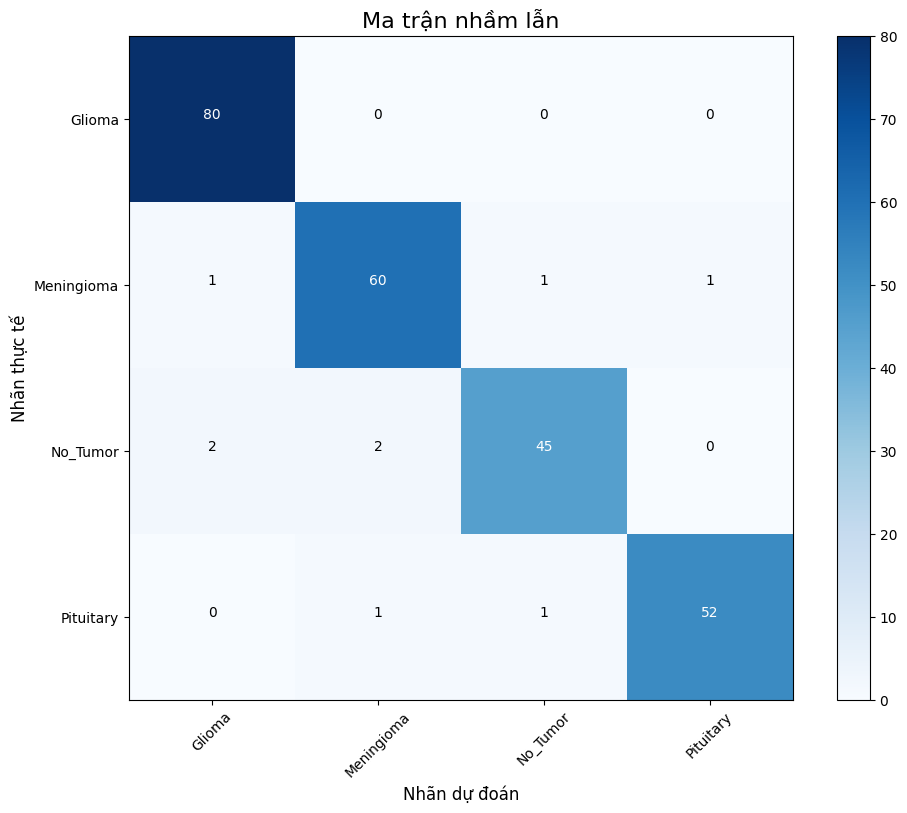

Ma trận nhầm lẫn được chuẩn hóa


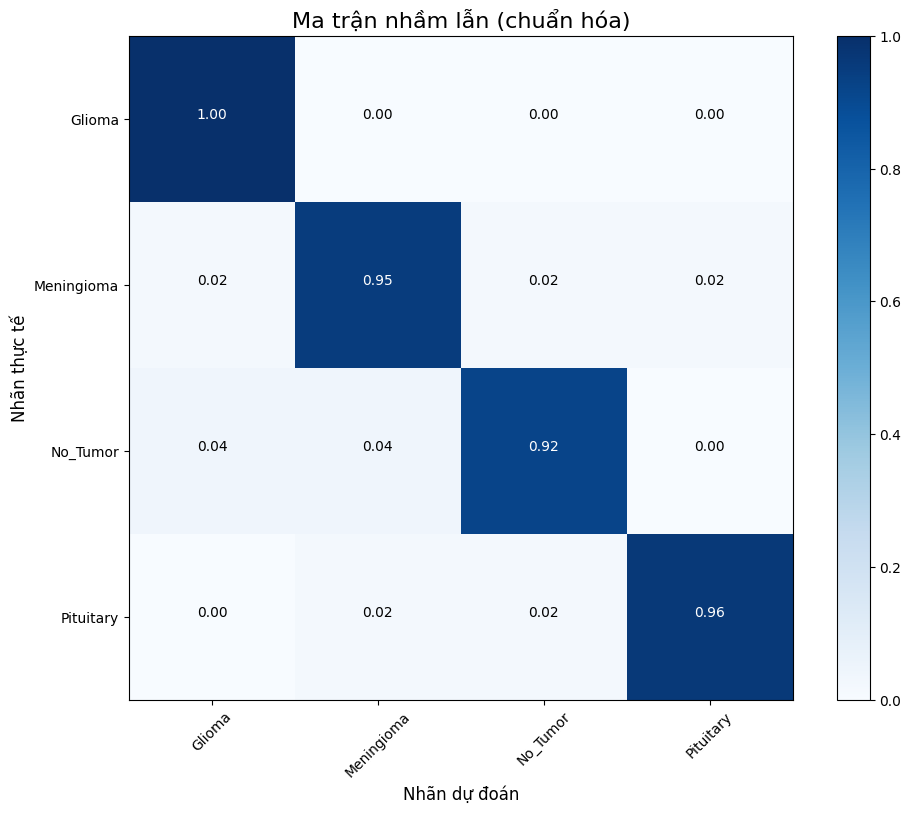

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


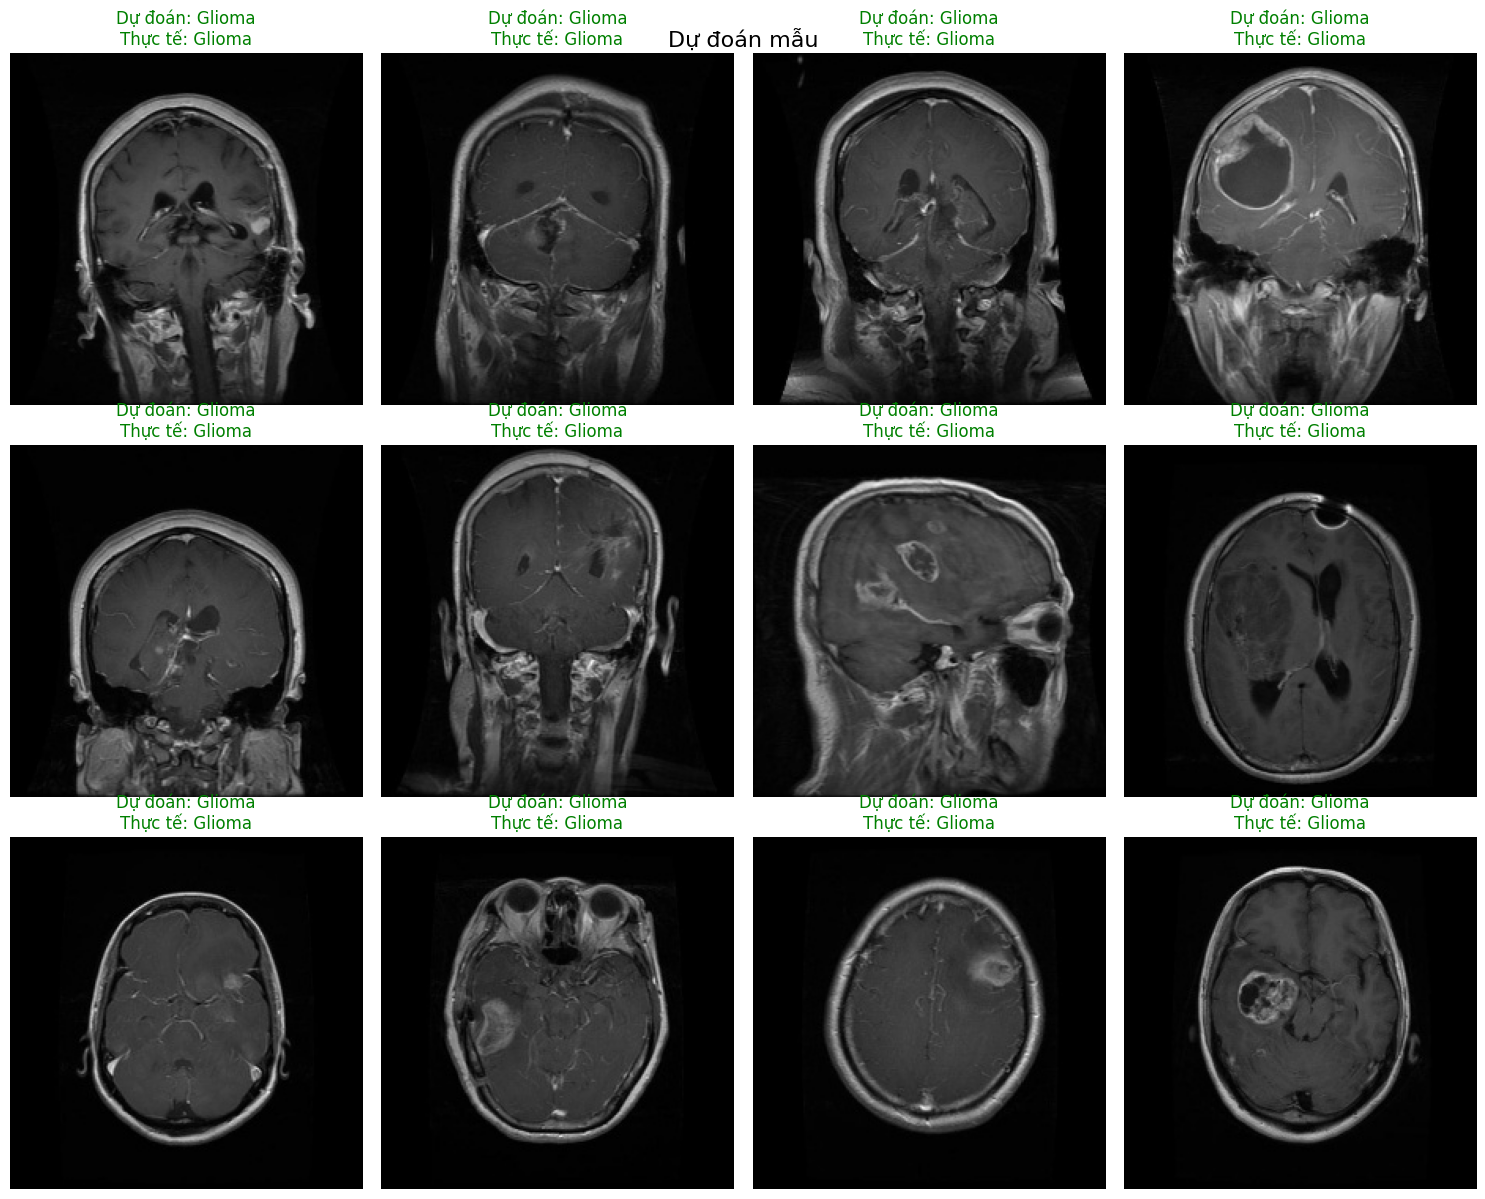

Độ chính xác lớp Glioma: 1.0000
Độ chính xác lớp Meningioma: 0.9524
Độ chính xác lớp No_Tumor: 0.9184
Độ chính xác lớp Pituitary: 0.9630


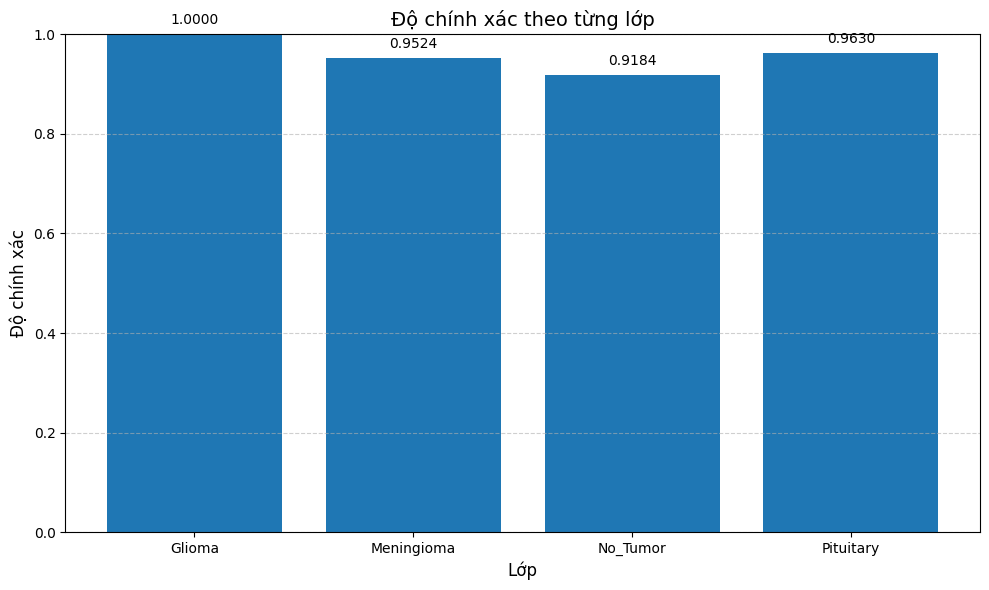

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import itertools

# 1. Tải mô hình đã huấn luyện (nếu đã lưu)
# Nếu bạn đã sử dụng ModelCheckpoint để lưu mô hình
model = load_model('best_resnet_attention_model.h5')
# Hoặc sử dụng model đã huấn luyện nếu đang trong cùng session

# 2. Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_gen)
print(f"Độ chính xác trên tập test: {test_acc:.4f}")
print(f"Loss trên tập test: {test_loss:.4f}")

# 3. Dự đoán trên tập test
# Đặt lại generator để đảm bảo dự đoán đúng thứ tự
test_gen.reset()

# Dự đoán
y_pred = model.predict(test_gen, steps=len(test_gen))
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
# Lưu ý: vì generator có thể padding batch cuối cùng, nên chỉ lấy đúng số mẫu test
true_classes = test_gen.classes[:len(y_pred_classes)]

# Lấy tên các lớp
class_labels = list(test_gen.class_indices.keys())

# 4. Báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết:")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

# 5. Vẽ ma trận nhầm lẫn
def plot_confusion_matrix(cm, classes, normalize=False, title='Ma trận nhầm lẫn', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Ma trận nhầm lẫn được chuẩn hóa")
    else:
        print("Ma trận nhầm lẫn không chuẩn hóa")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Nhãn thực tế', fontsize=12)
    plt.xlabel('Nhãn dự đoán', fontsize=12)
    plt.show()

# Tính ma trận nhầm lẫn
cnf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn không chuẩn hóa
plot_confusion_matrix(cnf_matrix, classes=class_labels, title='Ma trận nhầm lẫn')

# Vẽ ma trận nhầm lẫn chuẩn hóa
plot_confusion_matrix(cnf_matrix, classes=class_labels, normalize=True, title='Ma trận nhầm lẫn (chuẩn hóa)')

# 6. Vẽ đường cong học tập (nếu bạn có history từ quá trình huấn luyện)
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Vẽ đường cong accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Vẽ đường cong loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Nếu bạn có history, hãy vẽ các đường cong học tập
# Bỏ comment dòng dưới nếu bạn có history
# plot_learning_curves(history)

# 7. Hiển thị một số ảnh và dự đoán
def display_predictions(generator, model, num_samples=12):
    plt.figure(figsize=(15, 12))

    # Lấy batch đầu tiên để hiển thị
    generator.reset()
    batch_x, batch_y = next(generator)

    # Dự đoán
    predictions = model.predict(batch_x)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_y, axis=1)

    # Lấy tên lớp
    classes = list(generator.class_indices.keys())

    # Hiển thị ảnh cùng với dự đoán
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(3, 4, i+1)
        plt.imshow(batch_x[i])

        # Xác định màu cho tiêu đề (xanh nếu đúng, đỏ nếu sai)
        if pred_classes[i] == true_classes[i]:
            color = 'green'
        else:
            color = 'red'

        # Hiển thị tiêu đề
        title = f"Dự đoán: {classes[pred_classes[i]]}\nThực tế: {classes[true_classes[i]]}"
        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Dự đoán mẫu', fontsize=16, y=0.98)
    plt.show()

# Hiển thị một số dự đoán
display_predictions(test_gen, model)

# 8. Đánh giá tỉ lệ đúng của từng lớp
class_acc = {}
for i, class_name in enumerate(class_labels):
    # Lấy chỉ số của các mẫu thuộc lớp i
    class_indices = np.where(true_classes == i)[0]
    # Tính accuracy cho lớp này
    class_acc[class_name] = accuracy_score(
        true_classes[class_indices],
        y_pred_classes[class_indices]
    )
    print(f"Độ chính xác lớp {class_name}: {class_acc[class_name]:.4f}")

# Vẽ biểu đồ độ chính xác theo lớp
plt.figure(figsize=(10, 6))
plt.bar(class_acc.keys(), class_acc.values())
plt.title('Độ chính xác theo từng lớp', fontsize=14)
plt.xlabel('Lớp', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(class_acc.values()):
    plt.text(i, v+0.02, f"{v:.4f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()